## Install libraries

In [5]:
!pip install shekar -q
# !pip install shekar datasets transformers scikit-learn tensorflow accelerate -q

## Impoert Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from datasets import load_dataset

from shekar.normalizer import Normalizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset, ClassLabel, Features, Value

from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

## Loade and Analyze the data

Train dataframe missing values:
 comment     0
label       0
label_id    0
dtype: int64
Test dataframe missing values:
 comment     0
label       0
label_id    0
dtype: int64


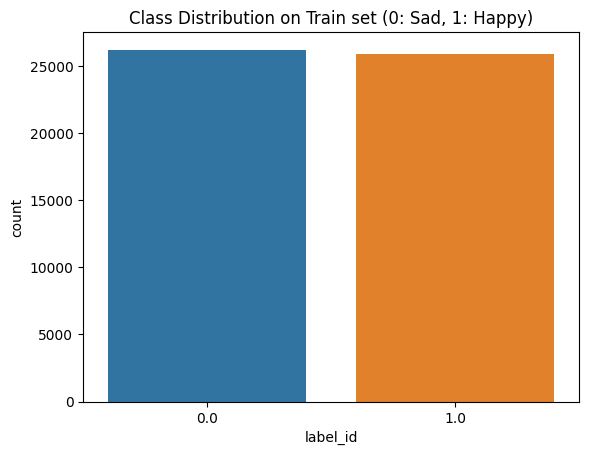

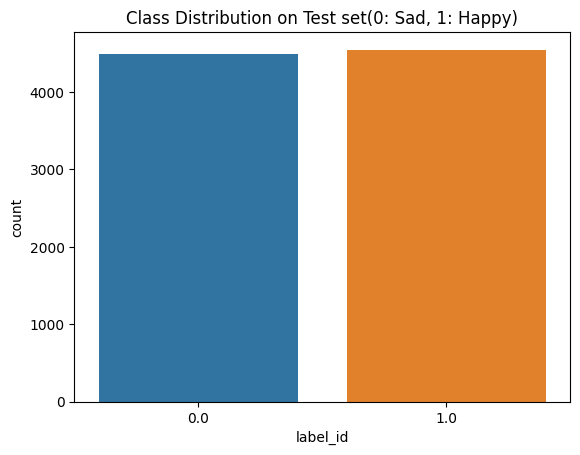

Train Size: 52110
Test Size: 9033
                                             comment  label  label_id
0   غذا خیلی سرد بود در صورتیکه فاصله ما خیلی کم است    SAD       1.0
1     بهتره بتونیم ران یا سینه رو خودمون انتخاب کنیم  HAPPY       0.0
2  غذا بد بود حالم خیییییلی بده. دل دردو دل پیچه....    SAD       1.0


In [7]:
dataset = load_dataset("ParsiAI/snappfood-sentiment-analysis")

train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

print("Train dataframe missing values:\n", train_df.isnull().sum())
print("Test dataframe missing values:\n", test_df.isnull().sum())

# Visualize Class Balance
sns.countplot(x=train_df['label_id'])
plt.title("Class Distribution on Train set (0: Sad, 1: Happy)")
plt.show()

sns.countplot(x=test_df['label_id'])
plt.title("Class Distribution on Test set(0: Sad, 1: Happy)")
plt.show()

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")
print(train_df.head(3))

## Normalizing the data

In [8]:
normalizer = Normalizer()

train_df['clean_text'] = train_df['comment'].apply(normalizer)
test_df['clean_text'] = test_df['comment'].apply(normalizer)

# Remove empty rows if any resulted from filtering
train_df = train_df[train_df['clean_text'].str.strip().astype(bool)]
test_df = test_df[test_df['clean_text'].str.strip().astype(bool)]

print(f"Original: {train_df['comment'].iloc[3]}")
print(f"Cleaned : {train_df['clean_text'].iloc[3]}")

Original: با سلام سابق بر این بسته بندی از کیفیت بهتری برخوردار بود. ولی در حال حاضر ایراداتی وجود داره. به طور نمونه نوشابه قوطی فاقد نی هست، چنگال برای سرو سیب زمینی نداره، دستمال کاغذی هم در بسته بندی نیست.
Cleaned : با سلام سابق بر این بسته‌بندی از کیفیت بهتری برخوردار بود. ولی در حال حاضر ایراداتی وجود داره. به‌طور نمونه نوشابه قوطی فاقد نی هست، چنگال برای سرو سیب‌زمینی نداره، دستمال کاغذی هم در بسته‌بندی نیست.


## Vectorization using TF-IDF

In [9]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
X_test_tfidf = tfidf.transform(test_df['clean_text'])

y_train = train_df['label_id']
y_test = test_df['label_id']

## Taining classic Models

In [10]:
# LogisticRegression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)
print(f"\n=== LogisticRegression ===")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# MultinomialNB
model_mnb = MultinomialNB()
model_mnb.fit(X_train_tfidf, y_train)
y_pred_mnb = model_mnb.predict(X_test_tfidf)
print(f"\n=== MultinomialNB ===")
print(classification_report(y_test, y_pred_mnb))
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))

# RandomForest
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)
print(f"\n=== RandomForest ===")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


=== LogisticRegression ===
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      4486
         1.0       0.84      0.89      0.86      4547

    accuracy                           0.86      9033
   macro avg       0.86      0.86      0.86      9033
weighted avg       0.86      0.86      0.86      9033

Accuracy: 0.8575224178013949

=== MultinomialNB ===
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.83      4486
         1.0       0.81      0.91      0.86      4547

    accuracy                           0.85      9033
   macro avg       0.85      0.85      0.84      9033
weighted avg       0.85      0.85      0.84      9033

Accuracy: 0.845566257057456

=== RandomForest ===
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85      4486
         1.0       0.83      0.89      0.86      4547

    accuracy                           0.85      903

## Data preparation for LSTM

In [11]:
# Parameters
VOCAB_SIZE = 20000
MAX_LEN = 100
EMBEDDING_DIM = 100

# Tokenize
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Data shape: {X_train_pad.shape}")

Data shape: (52110, 100)


## Build and Train LSTM

In [12]:
model_lstm = Sequential()

# Embedding Layer
model_lstm.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))

# First Bidirectional LSTM Layer
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_lstm.add(Dropout(0.4))
model_lstm.add(BatchNormalization())

# Second Bidirectional LSTM Layer
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dropout(0.4))
model_lstm.add(BatchNormalization())

# Dense Layers for classification
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train
print("Training LSTM")
history = model_lstm.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Evaluate
y_pred_probs = model_lstm.predict(X_test_pad)
y_pred_lstm = (y_pred_probs > 0.5).astype(int)

print("\n--- LSTM ---")
print(classification_report(y_test, y_pred_lstm))
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))

Training LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1764149650.279447     551 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/5


I0000 00:00:1764149656.536000     628 cuda_dnn.cc:529] Loaded cuDNN version 90300


733/733 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.7673 - loss: 0.4919 - val_accuracy: 0.8202 - val_loss: 0.4275
Epoch 2/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8730 - loss: 0.3096 - val_accuracy: 0.8555 - val_loss: 0.3440
Epoch 3/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8958 - loss: 0.2564 - val_accuracy: 0.8495 - val_loss: 0.3743
Epoch 4/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9074 - loss: 0.2222 - val_accuracy: 0.8409 - val_loss: 0.4476
Epoch 5/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9236 - loss: 0.1907 - val_accuracy: 0.8440 - val_loss: 0.4564
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

--- LSTM ---
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83      4486
         1.0       0.83      0.86      0.84      4547

    accuracy                           0.84      9033
   macro avg       0.84      0.84      0.84      9033
weighted avg       0.84      0.84    

## ParsBERT Tokenization and Data Type Casting

In [13]:
# Load ParsBERT Tokenizer
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_checkpoint)

# Function to tokenize data
def tokenize_function(examples):
    return tokenizer_bert(examples["clean_text"], padding="max_length", truncation=True, max_length=128)

# Force labels to be integers
train_df['label_id'] = train_df['label_id'].astype(int)
test_df['label_id'] = test_df['label_id'].astype(int)

# Define Features to ensure Hugging Face treats this as Classification
features = Features({
    'clean_text': Value('string'),
    'label': ClassLabel(num_classes=2, names=['sad', 'happy'])
})

# Convert pandas to HF Dataset with explicit features
hf_train = Dataset.from_pandas(train_df[['clean_text', 'label_id']].rename(columns={'label_id': 'label'}), features=features)
hf_test = Dataset.from_pandas(test_df[['clean_text', 'label_id']].rename(columns={'label_id': 'label'}), features=features)

# Apply tokenization
encoded_train = hf_train.map(tokenize_function, batched=True)
encoded_test = hf_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/52110 [00:00<?, ? examples/s]

Map:   0%|          | 0/9033 [00:00<?, ? examples/s]

## Load Pre-trained Model, Set Training Arguments and Train the model

In [14]:
# Load Pre-trained Model
model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    problem_type="single_label_classification"
)

# Training Arguments
args = TrainingArguments(
    output_dir="bert-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

# Define Trainer
trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# Train
trainer.train()

# Get Predictions
predictions_bert = trainer.predict(encoded_test)
y_pred_bert = np.argmax(predictions_bert.predictions, axis=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.291100,0.306833,0.874017


## Compare Results from all models


=== Final Model Comparison ===


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.857522,0.835391,0.892896,0.863187
1,Multinomial NB,0.845566,0.807572,0.910051,0.855754
2,Random Forest,0.852762,0.827397,0.893996,0.859408
3,LSTM,0.837706,0.828115,0.855069,0.841376
4,ParsBERT,0.874017,0.846232,0.916208,0.879831


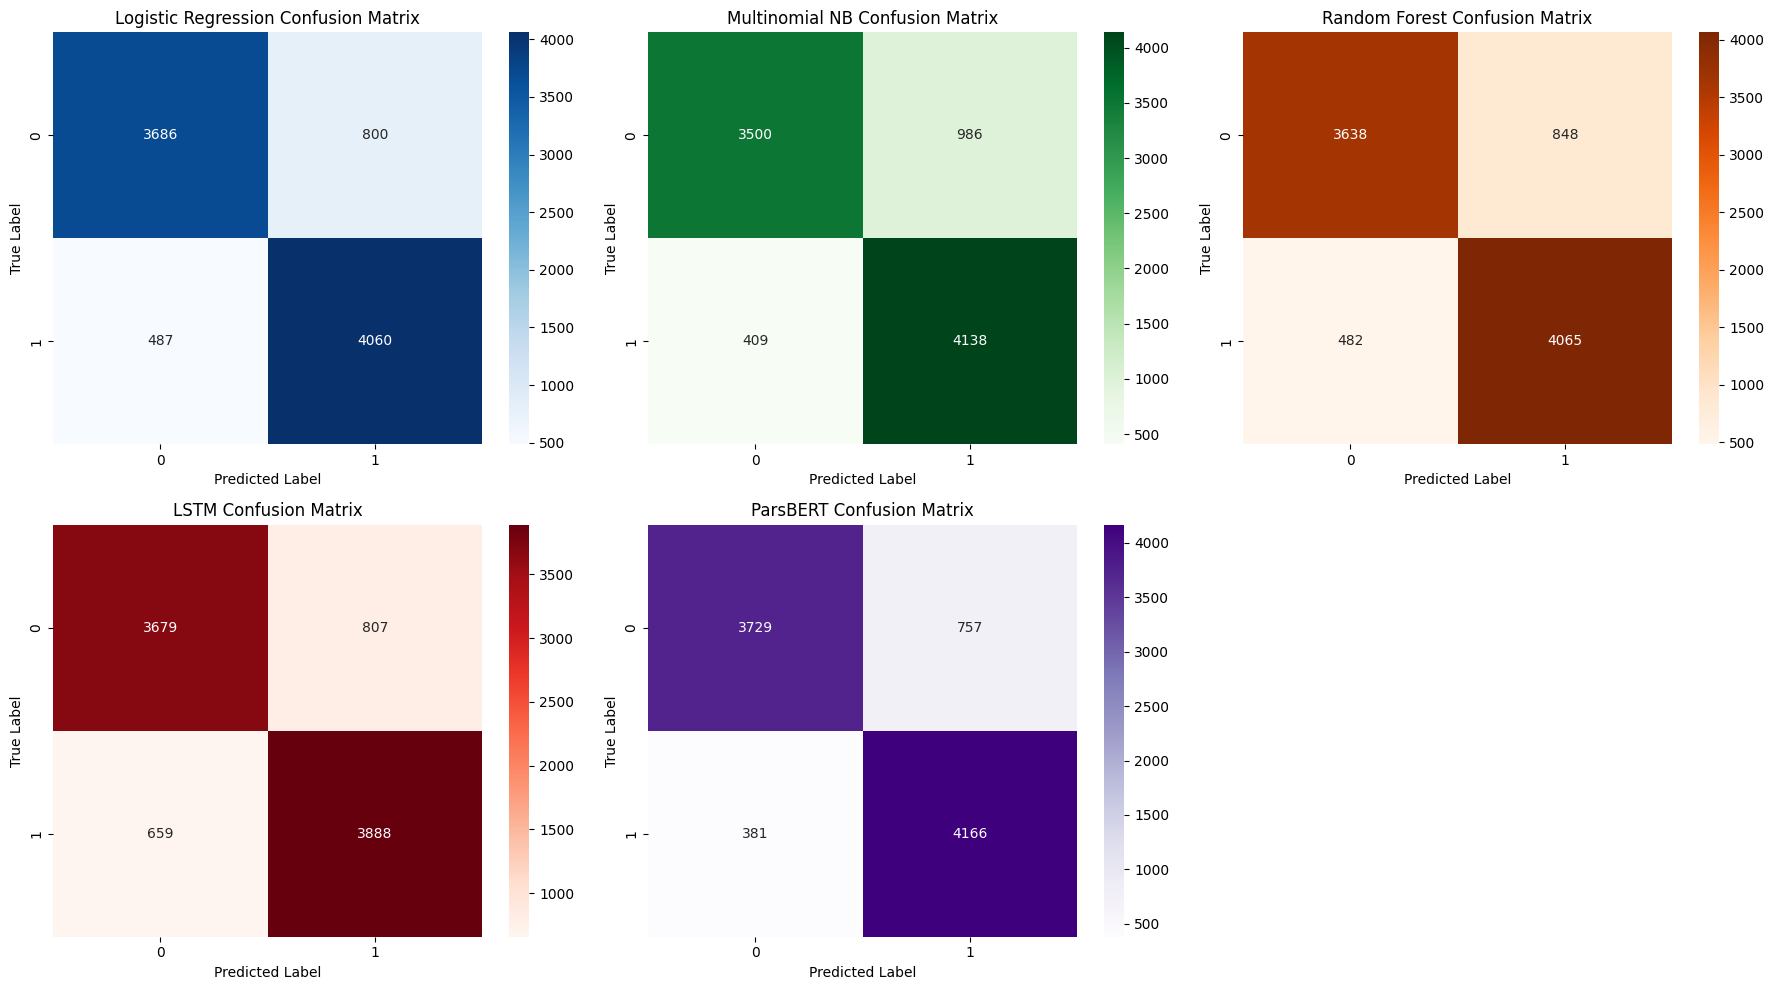

In [ ]:
# Function to calculate all metrics
def get_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0)
    }

# Gather Results from all models
results = [
    get_metrics(y_test, y_pred_lr, "Logistic Regression"),
    get_metrics(y_test, y_pred_mnb, "Multinomial NB"),
    get_metrics(y_test, y_pred_rf, "Random Forest"),
    get_metrics(y_test, y_pred_lstm, "LSTM"),
    get_metrics(y_test, y_pred_bert, "ParsBERT")
]

# Create and Display DataFrame
results_df = pd.DataFrame(results)
print("\n=== Final Model Comparison ===")
display(results_df)

# Plot Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# List of models
models_data = [
    ("Logistic Regression", y_pred_lr, "Blues"),
    ("Multinomial NB", y_pred_mnb, "Greens"),
    ("Random Forest", y_pred_rf, "Oranges"),
    ("LSTM", y_pred_lstm, "Reds"),
    ("ParsBERT", y_pred_bert, "Purples")
]

# Loop through models and plot
for i, (name, preds, cmap) in enumerate(models_data):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap=cmap)
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

axes[5].axis('off')

plt.tight_layout()
plt.show()

## Conclusion
After comparing five different models, here is the breakdown of what we can see:

* As expected, **`ParsBERT`** took the top spot with an **accuracy** of `87.4%` and the highest **F1 Score** (`88%`) with just 1 epoch! Because it is pre-trained specifically on the Persian language, it understands the context of the comments much better than the other models. It was particularly good at identifying "Happy" comments (highest Recall), making it the most reliable choice.

* **`Logistic regression`** came in second with an **accuracy** of `85.8%`, outperforming the more complex Random Forest and LSTM models. This proves that for this particular dataset, a simple, fast, and lightweight model is very effective.

* **`Multinomial Naive Bayes`** achieved a very high **Recall** (`91.0%`), nearly matching ParsBERT. However, it had the lowest **Precision** (`80.8%`). This means the model is very good at catching positive sentiments but produces more False Positives (classifying Sad comments as Happy) compared to the others.

* The **`LSTM`** model performed the worst among the five models (**Accuracy**: `83.8%`). While LSTMs are generally powerful for sequence data, in this specific scenario it failed to outperform even the simple Bag-of-Words/TF-IDF baseline models(the added complexity of the neural network didn't pay off).